In [1072]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import import_ipynb
from coare36vn_zrf_et import psiu_40, psiu_26
from metpy import calc
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit, Bounds

# Read in LES

In [2]:
LES_data = 'MidPlane_means.csv'

In [3]:
LES_df = pd.read_csv(LES_data)
x_coast = LES_df['X'].unique() - 3000
height = LES_df['Z'].unique()

# Create an xarray Dataset with the 2D data
ds = xr.Dataset(
    coords={
        'Height': height,
        'X_coast': x_coast,
    }
)

for n,name in enumerate(LES_df.columns.to_list()):
    if name=='X' or name=='Z':
        continue
    else:
        # Expand the variables to 2D by repeating along the Z axis (broadcasting)
        var_tmp = LES_df[name].values
        var_2d = np.reshape(var_tmp, (len(height), len(x_coast)))
        
        name = name.replace("'", 'p')
        name = name.replace('THETA', 'T')
        name = name.replace(' ', '')
        ds[name] = (['Height', 'X_coast'], var_2d)   
ds

<xarray.Dataset> Size: 4MB
Dimensions:  (Height: 119, X_coast: 320)
Coordinates:
  * Height   (Height) float64 952B 0.7906 2.384 4.004 5.65 ... 479.7 487.5 495.5
  * X_coast  (X_coast) float64 3kB -996.1 -988.3 -980.5 ... 1.488e+03 1.496e+03
Data variables: (12/13)
    U        (Height, X_coast) float64 305kB 3.203 3.205 3.202 ... 4.701 4.702
    W        (Height, X_coast) float64 305kB -0.005786 0.006266 ... 0.02308
    V        (Height, X_coast) float64 305kB -0.0147 -0.01553 ... 0.01469
    T        (Height, X_coast) float64 305kB 286.1 286.1 286.1 ... 299.3 299.3
    UpUp     (Height, X_coast) float64 305kB 0.2301 0.2508 ... 0.003109 0.003112
    WpWp     (Height, X_coast) float64 305kB 0.007696 0.007576 ... 0.005745
    ...       ...
    TKE      (Height, X_coast) float64 305kB 0.1779 0.1856 ... 0.007984 0.007968
    TpTp     (Height, X_coast) float64 305kB 0.01527 0.0009889 ... 0.00905
    UpWp     (Height, X_coast) float64 305kB -0.008249 -0.008026 ... 0.0005816
    WpTp     (Height, X_coast) float64 305kB -0.0008152 -0.0006877 ... -0.002288
    UpVp     (Height, X_coast) float64 305kB -0.05249 -0.04971 ... -1.06e-05
    VpWp     (Height, X_coast) float64 305kB 0.00974 0.007745 ... -6.96e-05

## Diagnostics

In [ ]:

g = 9.81
vonk = 0.4
f = 2*np.sin(36.5*np.pi/180)*(7.29e-5)

wsp = (ds.U**2 + ds.V**2 + ds.W**2)**(1/2)
hwsp = (ds.U**2 + ds.V**2)**(1/2)
ust = (ds.UpWp**2 + ds.VpWp**2)**(1/4)
wst = (ds.Height*g*ds.WpTp / ds.T)**(1/3)
Lob = -(ds.T*ust**3) / (vonk*g*ds.WpTp)
zL = ds.Height / Lob
Tadv = np.tile(ds.X_coast.values, (len(ds.Height.values), 1)) / ds.U.values
gamma = calc.first_derivative(ds.T)
N2 = (g/ds.T)*gamma

psiu = np.zeros(zL.values.shape, dtype=float)
for z,height in enumerate(ds.Height.values):
    psiu[z,:] = psiu_40(zL.isel(Height=z).values)

psiu[psiu < -100] = np.nan
z0 = np.transpose(np.tile(ds.Height.values, (len(ds.X_coast.values), 1))) * np.exp(-(vonk*wsp/ust + psiu))

ds['wsp'] = (['Height', 'X_coast'], wsp.values)   
ds['hwsp'] = (['Height', 'X_coast'], hwsp.values)   
ds['ustar'] = (['Height', 'X_coast'], ust.values)   
ds['wstar'] = (['Height', 'X_coast'], wst.values)   
ds['L_ob'] = (['Height', 'X_coast'], Lob.values)   
ds['zL'] = (['Height', 'X_coast'], zL.values)   
ds['Tadv'] = (['Height', 'X_coast'], Tadv)
ds['z0'] = (['Height', 'X_coast'], z0.values)
ds

# Plots

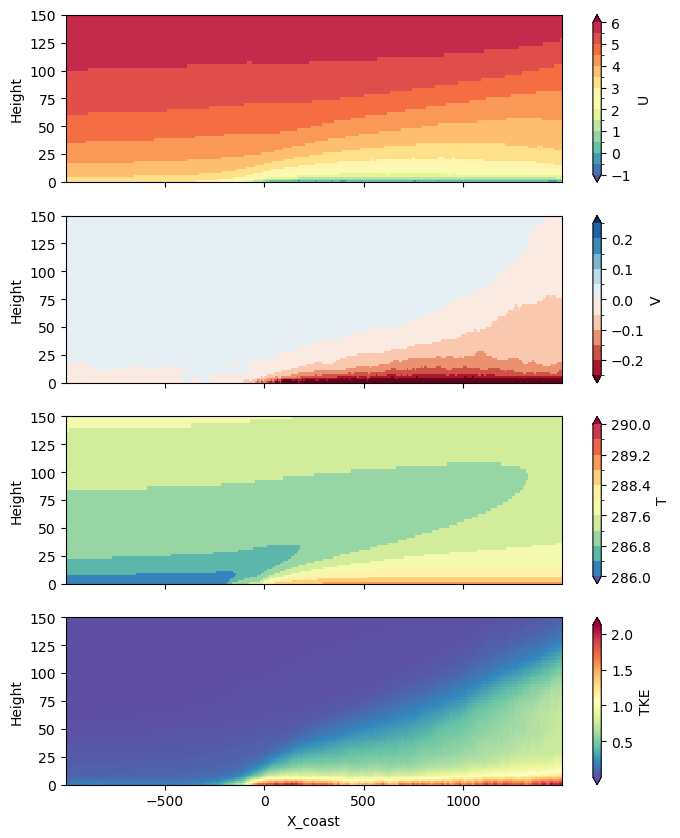

In [61]:
## quick plots

fig, ax = plt.subplots(4,1, figsize=(8,10), sharex=True)
ax = ax.flatten()

ds.U.plot(ax=ax[0], x='X_coast', y='Height', cmap='Spectral_r', levels=np.linspace(-1, 6, 15), extend='both')
ds.V.plot(ax=ax[1], x='X_coast', y='Height', cmap='RdBu', levels=np.linspace(-0.25, 0.25, 11), extend='both')
ds.T.plot(ax=ax[2], x='X_coast', y='Height', cmap='Spectral_r', levels=np.linspace(286, 290, 11), extend='both')
ds.TKE.plot(ax=ax[3], x='X_coast', y='Height', cmap='Spectral_r', extend='both')

for n,axis in enumerate(ax):
    axis.set_ylim([0, 150])
    if n<3: axis.set_xlabel('')

fig.savefig('LES_quick_look.png', bbox_inches='tight', dpi=200)

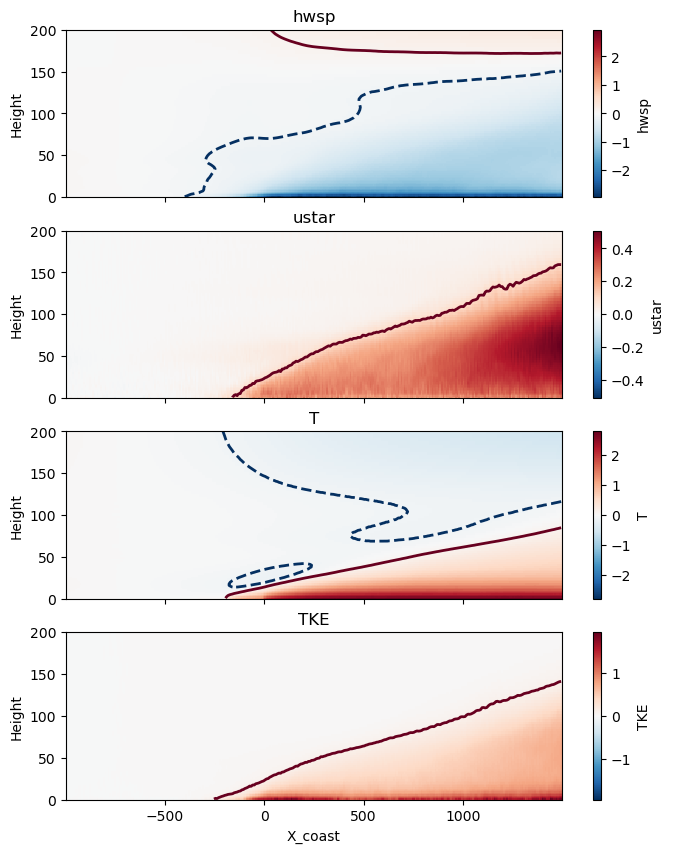

In [14]:
## quick plots

upstream_mask = (ds.X_coast <= -500)

fig, ax = plt.subplots(4,1, figsize=(8,10), sharex=True)
ax = ax.flatten()

for n,var in enumerate(['hwsp', 'ustar', 'T', 'TKE']):
    var_upstream = ds[var].where(upstream_mask, drop=True).mean(dim='X_coast')
    var_plt = ds[var] - var_upstream

    var_plt.plot(ax=ax[n], x='X_coast', y='Height')
    var_plt.plot.contour(ax=ax[n], x='X_coast', y='Height', levels=[-0.1, 0.1], linewidths=2)
    
    ax[n].set_title(f'{var}')
    ax[n].set_ylim([0, 200])
    if n<3: ax[n].set_xlabel('')

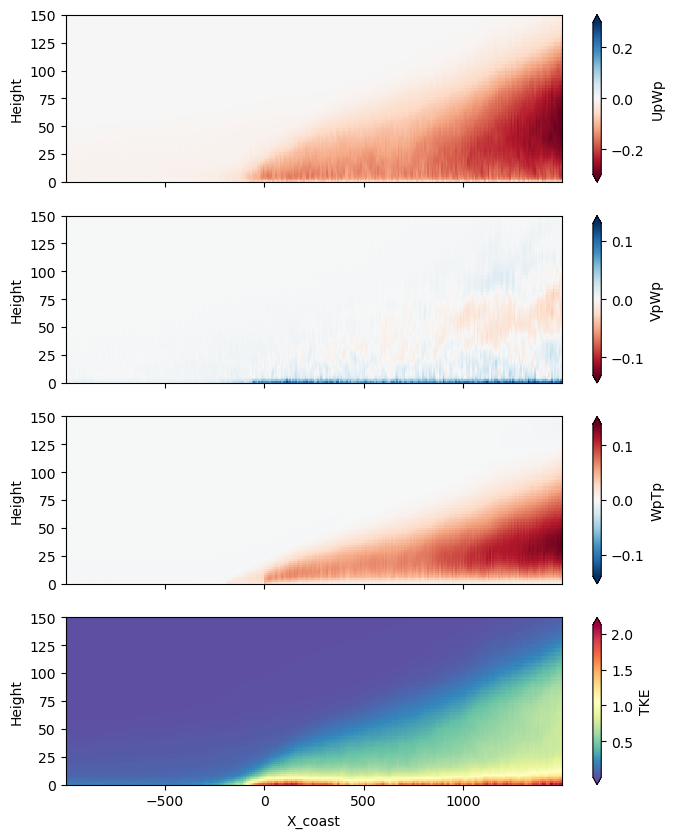

In [63]:
## quick plots

fig, ax = plt.subplots(4,1, figsize=(8,10), sharex=True)
ax = ax.flatten()

ds.UpWp.plot(ax=ax[0], x='X_coast', y='Height', cmap='RdBu', extend='both')
ds.VpWp.plot(ax=ax[1], x='X_coast', y='Height', cmap='RdBu', extend='both')
ds.WpTp.plot(ax=ax[2], x='X_coast', y='Height', cmap='RdBu_r',extend='both')
ds.TKE.plot(ax=ax[3], x='X_coast', y='Height', cmap='Spectral_r', extend='both')

for n,axis in enumerate(ax):
    axis.set_ylim([0, 150])
    if n<3: axis.set_xlabel('')

fig.savefig('LES_quick_look_fluxes.png', bbox_inches='tight', dpi=200)

/Users/jameshlywiak/miniconda3/envs/ABL/lib/python3.12/site-packages/numpy/core/function_base.py:298: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


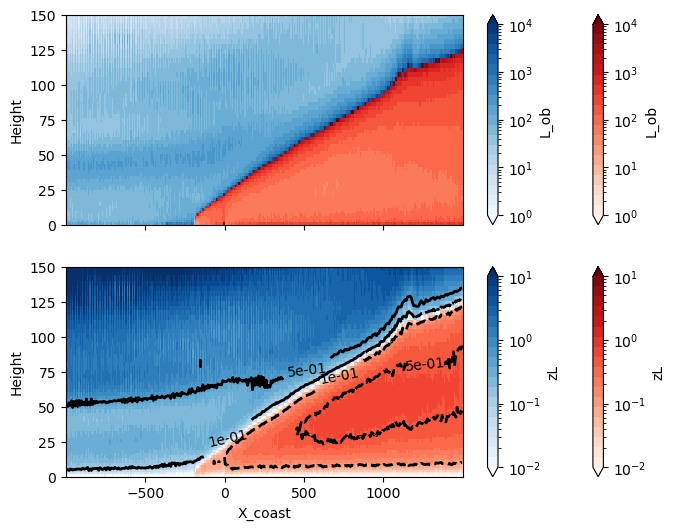

In [390]:
saveplt = 0

fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=True)
ax = ax.flatten()

(-1*ds.L_ob.where(ds.L_ob<=0)).plot(ax=ax[0], x='X_coast', y='Height', cmap='Reds',extend='both', 
                            levels=np.logspace(1, 10000, 20), norm=LogNorm(vmin=1, vmax=10000))
ds.L_ob.where(ds.L_ob>=0).plot(ax=ax[0], x='X_coast', y='Height', cmap='Blues',extend='both', 
                            levels=np.logspace(1, 10000, 20), norm=LogNorm(vmin=1, vmax=10000))
(-1*ds.zL.where(ds.zL<=0)).plot(ax=ax[1], x='X_coast', y='Height', cmap='Reds',extend='both', 
                            levels=np.logspace(0.01, 10, 20), norm=LogNorm(vmin=0.01, vmax=10))
ds.zL.where(ds.zL>=0).plot(ax=ax[1], x='X_coast', y='Height', cmap='Blues',extend='both', 
                            levels=np.logspace(0.01, 10, 20), norm=LogNorm(vmin=0.01, vmax=10))

c1=(-1*ds.zL.where(ds.zL<=0)).plot.contour(ax=ax[1], x='X_coast', y='Height', 
                                           levels=[1e-1, 5e-1, 1, 1e1], linewidths=2, colors='k', linestyles='--')
c2=ds.zL.where(ds.zL>=0).plot.contour(ax=ax[1], x='X_coast', y='Height', 
                                      levels=[1e-1, 5e-1], linewidths=2, colors='k')
plt.clabel(c1, inline=True, fmt='%.e')
plt.clabel(c2, inline=True, fmt='%.e')

for n,axis in enumerate(ax):
    axis.set_ylim([0, 150])
    if n<1: axis.set_xlabel('')

if saveplt == 1:
    fig.savefig('LES_quick_look_Lob.png', bbox_inches='tight', dpi=200)

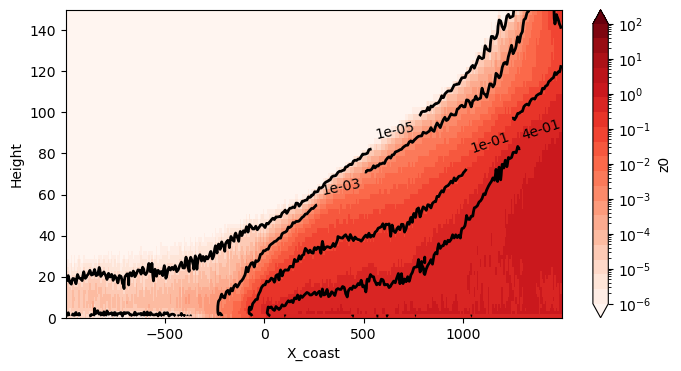

In [469]:
saveplt = 0

fig, ax = plt.subplots(1,1, figsize=(8,4), sharex=True)

ds.z0.where(ds.z0<10000).plot(ax=ax, x='X_coast', y='Height', cmap='Reds',extend='both', 
                              levels=np.logspace(1e-6, 100, 20), norm=LogNorm(vmin=1e-6, vmax=100))
c1=ds.z0.where(ds.z0<10000).plot.contour(ax=ax, x='X_coast', y='Height', 
                                         levels=[1e-5, 1e-3, 1e-1, 0.42], linewidths=2, colors='k')

plt.clabel(c1, inline=True, fmt='%.e')
ax.set_ylim([0, 150])

if saveplt == 1:
    fig.savefig('LES_2D_z0.png', bbox_inches='tight', dpi=200)

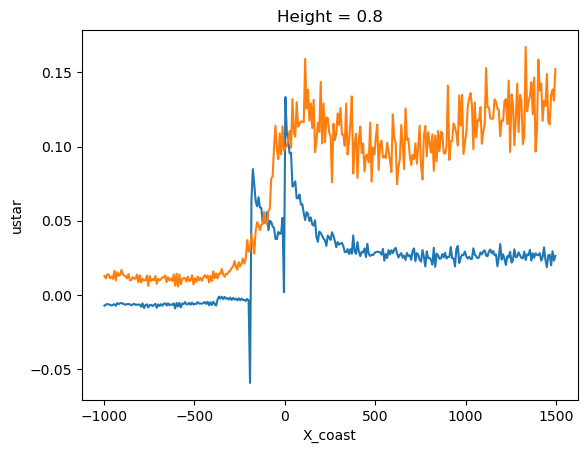

In [397]:
ds_plt = ds.interp(Height=0.8)

(ds_plt.WpTp/ds_plt.ustar).plot(x='X_coast', label='t*')
(ds_plt.ustar**2).plot(x='X_coast', label='u*')

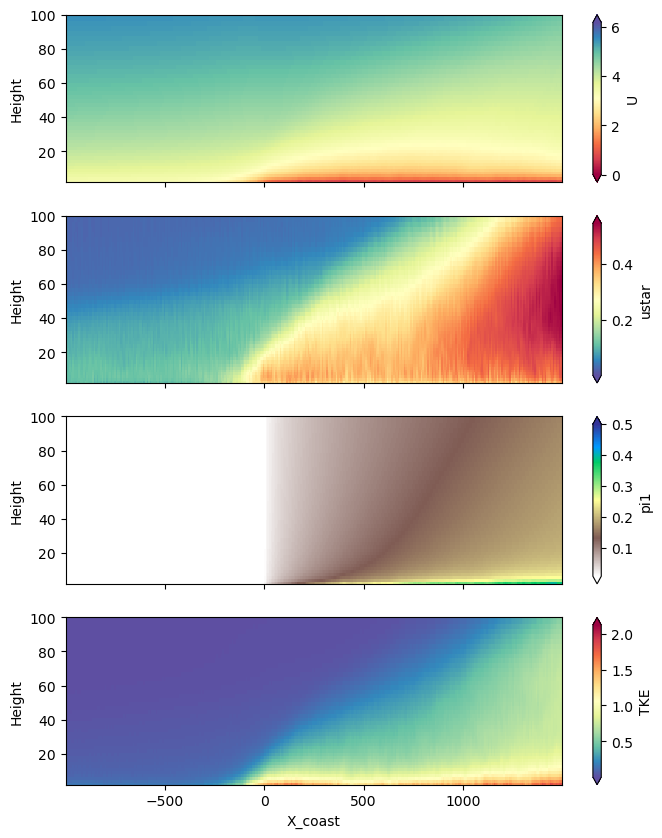

In [115]:
## quick plots

saveplt = 0

fig, ax = plt.subplots(4,1, figsize=(8,10), sharex=True)
ax = ax.flatten()

ds.U.plot(ax=ax[0], x='X_coast', y='Height', cmap='Spectral', extend='both', vmin=0)
ds.ustar.plot(ax=ax[1], x='X_coast', y='Height', cmap='Spectral_r', extend='both')
ds.pi1.where(ds.Tadv>=0).plot(ax=ax[2], x='X_coast', y='Height', cmap='terrain_r', extend='both',
                            vmax=0.5)
                            #levels=np.logspace(0.1, 1000, 20), norm=LogNorm(vmin=0.1, vmax=1000))
ds.TKE.plot(ax=ax[3], x='X_coast', y='Height', cmap='Spectral_r', extend='both')

for n,axis in enumerate(ax):
    axis.set_ylim([2, 100])
    if n<3: axis.set_xlabel('')

if saveplt == 1:
    fig.savefig('LES_quick_look_fluxes.png', bbox_inches='tight', dpi=200)

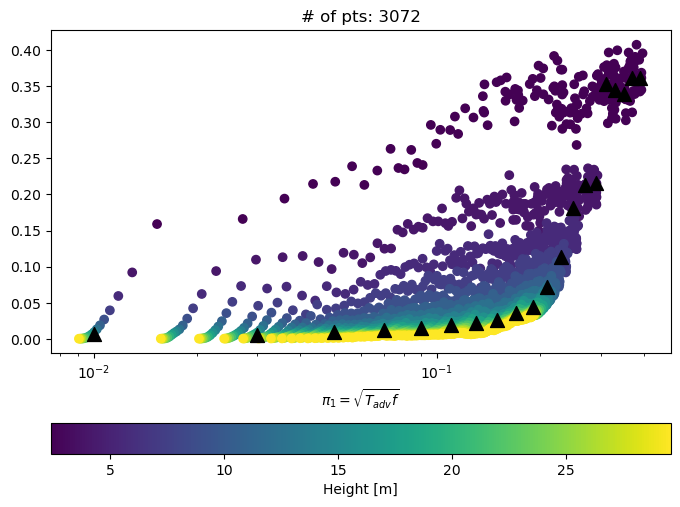

In [351]:
## all z0 below ~50 m

mask = (ds.Height <= 50) & (ds.Height >= 2) & (ds.X_coast >= 0) & (ds.z0<100) & (ds.z0>=1e-10)

pi1 = ds.pi1.where(mask, drop=True)
z0plt = ds.z0.where(mask, drop=True)
zplt = np.transpose(np.tile(z0plt.Height.values, (len(z0plt.X_coast.values), 1)))
pi2 = z0plt/zplt

bins = np.arange(0, 0.41, 0.02)
xplt = (bins[1:]+bins[:-1])/2
medians = np.zeros((len(bins)-1,))
for b,bin in enumerate(bins):
    if b==0: 
        prev_val = bin
    else:
        medians[b-1] = np.nanmedian(pi2.where((pi1>=prev_val) & (pi1<bin), drop=True).values)
        prev_val = bin

fig, ax = plt.subplots(1,1, figsize=(8,6))

p1=ax.scatter(pi1, pi2, c=zplt)
p2=ax.scatter(xplt, medians, c='k', marker='^', s=100)

ax.set_title(f'# of pts: {pi1.size}')

fig.colorbar(p1, location='bottom', label='Height [m]')
ax.set_xlabel(r'$\pi_1=\sqrt{T_{adv}f}$')
ax.set_xscale('log')

(0.0, 200.0)

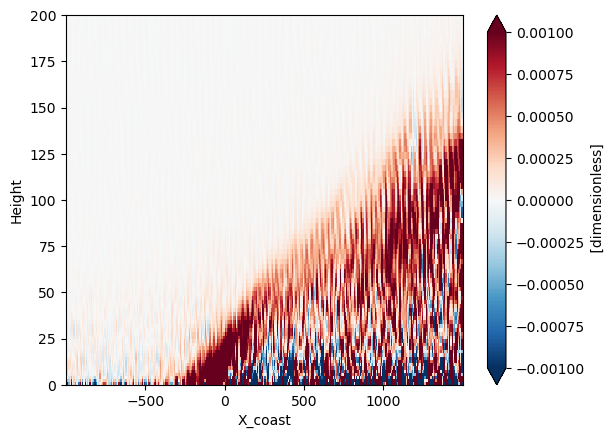

In [43]:
calc.first_derivative(ds.TKE, axis='X_coast').plot(x='X_coast', vmax=0.001)
ax=plt.gca()
ax.set_ylim([0, 200])

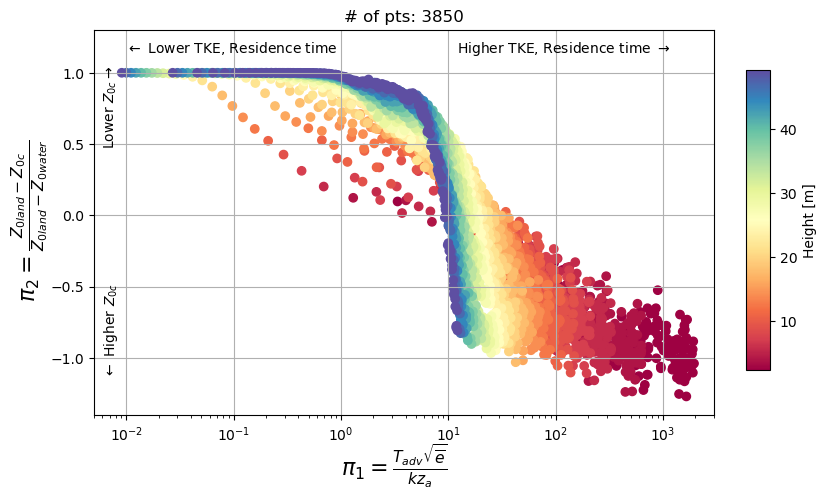

In [531]:
## all z0 below ~50 m

mask = (ds.Height <= 50) & (ds.Height >= 1) & (ds.X_coast >= 0) & (ds.X_coast <= 1200) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

X, Z = np.meshgrid(ds.X_coast, ds.Height)

tke_adv = ds.U * calc.first_derivative(ds.TKE, axis='X_coast')
gamma = calc.first_derivative(ds.T, axis='Height')
tke = ds.TKE
tadv = (X/ds.U)
buoyancy = g/ds.T
N2 = buoyancy * gamma
f = 2*np.sin(36.5*np.pi/180)*(7.29e-5)
z0_land = 0.42
z0_water = 0.00001

#pi1 = 1/(tke_adv / (buoyancy*ds.WpTp)).where(mask, drop=True)
#pi1 = (tadv*buoyancy*ds.WpTp/tke).where(mask, drop=True)
#pi1 = (Z*buoyancy*ds.WpTp/(ds.U**3)).where(mask, drop=True)
#pi1 = (ds.WpTp/(ds.U*gamma)).where(mask, drop=True) ### non-dim ibl height from Tampieri
pi1 = ((tadv**1)*(tke**(1/2))/(vonk*Z)).where(mask, drop=True) 
#pi1 = (X*N2/(ds.U*f)).where(mask, drop=True) 
#pi1 = 1/np.sqrt(X*f/ds.U).where(mask, drop=True) 
pi2 = ((z0_land-ds.z0)/(z0_land-z0_water)).where(mask, drop=True)

'''
bins = np.arange(0, 0.41, 0.02)
xplt = (bins[1:]+bins[:-1])/2
medians = np.zeros((len(bins)-1,))
for b,bin in enumerate(bins):
    if b==0: 
        prev_val = bin
    else:
        medians[b-1] = np.nanmedian(pi2.where((pi1>=prev_val) & (pi1<bin), drop=True).values)
        prev_val = bin
'''

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.grid()

p1=ax.scatter(pi1, pi2, c=Z[mask], cmap='Spectral')
#p2=ax.scatter(xplt, medians, c='k', marker='^', s=100)

ax.set_title(f'# of pts: {pi1.size}')
ax.annotate(r'$\leftarrow$ Lower TKE, Residence time',
            (1e-2, 1.14), fontsize=10)
ax.annotate(r'Higher TKE, Residence time $\rightarrow$ ', 
            (1.2e1, 1.14), fontsize=10)
ax.annotate(r'$\leftarrow$ Higher $Z_{0c}$', (6e-3, -1.1),  fontsize=10, rotation='vertical')
ax.annotate(r'Lower $Z_{0c} \rightarrow$ ', (6e-3, 0.5),  fontsize=10, rotation='vertical')

fig.supxlabel(r'$\pi_1=\frac{T_{adv}\sqrt{\overline{e}}}{kz_a}$', fontsize=16, y=-0.04)
fig.supylabel(r'$\pi_2=\frac{Z_{0land}-Z_{0c}}{Z_{0land}-Z_{0water}}$', fontsize=16, x=0.02)

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim([-1.4, 1.3])
ax.set_xlim([5e-3, 3e3])

cax = fig.add_axes([0.94, 0.2, 0.03, 0.6])
fig.colorbar(p1, cax=cax, label='Height [m]')


/var/folders/cs/zh92j6253ql06rbm236klql40000gn/T/ipykernel_63198/2056942373.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pi1.interp(Height=h), pi2.interp(Height=h), c=colors[q], label=f'z={h}', alpha=0.8)


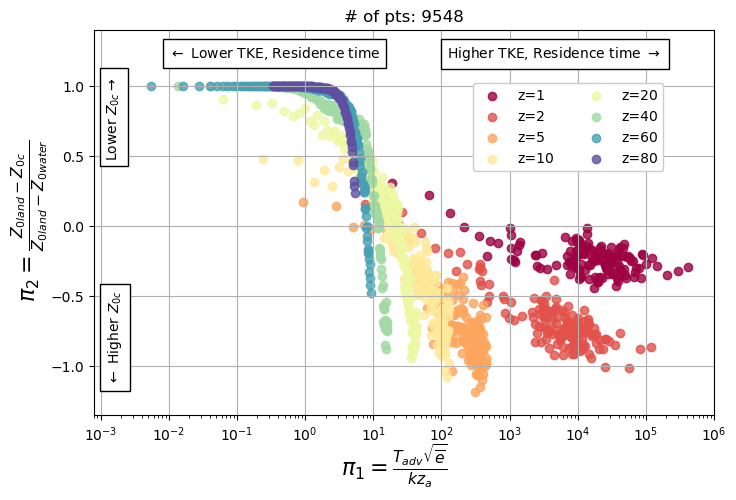

In [562]:
## select heights

qheight = [1, 2, 5, 10, 20, 40, 60, 80]
#qheight = [1]
mask = (ds.X_coast >= 0) & (ds.X_coast <= 1200) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

X, Z = np.meshgrid(ds.X_coast, ds.Height)

tke_adv = ds.U * calc.first_derivative(ds.TKE, axis='X_coast')
gamma = calc.first_derivative(ds.T, axis='Height')
tke = ds.TKE
tadv = (X/ds.U)
buoyancy = g/ds.T
N2 = buoyancy * gamma
f = 2*np.sin(36.5*np.pi/180)*(7.29e-5)
z0_land = 0.42
z0_water = 0.00001

pi1 = ((tadv**1)*(tke**(1/2))/(vonk*Z)).where(mask, drop=True) 
#pi1 = (X*N2/(ds.U*f)).where(mask, drop=True) 
#pi1 = 1/np.sqrt(X*f/ds.U).where(mask, drop=True) 
pi2 = ((z0_land - ds.z0)/(z0_land+z0_water)).where(mask, drop=True)

N = len(qheight)
cmap = cm.Spectral
colors = cmap(np.linspace(0, 1, N)) 

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.grid()

for q,h in enumerate(qheight):
    ax.scatter(pi1.interp(Height=h), pi2.interp(Height=h), c=colors[q], label=f'z={h}', alpha=0.8)

ax.set_title(f'# of pts: {pi1.size}')
ax.annotate(r'$\leftarrow$ Lower TKE, Residence time',
            (1e-2, 1.2), fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'Higher TKE, Residence time $\rightarrow$ ', 
            (1.2e2, 1.2), fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'$\leftarrow$ Higher $Z_{0c}$', (1.2e-3, -1.1),  fontsize=10, rotation='vertical', 
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'Lower $Z_{0c} \rightarrow$ ', (1.2e-3, 0.5),  fontsize=10, rotation='vertical',
            bbox=dict(facecolor='white', edgecolor='black'))

fig.supxlabel(r'$\pi_1=\frac{T_{adv}\sqrt{\overline{e}}}{kz_a}$', fontsize=16, y=-0.04)
fig.supylabel(r'$\pi_2=\frac{Z_{0land}-Z_{0c}}{Z_{0land}-Z_{0water}}$', fontsize=16, x=0.02)

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim([-1.35, 1.4])
ax.set_xlim([8e-4, 1e6])
ax.legend(ncol=2, bbox_to_anchor=(0.6, 0.88), framealpha=1)

In [909]:
def tanh(x, a, b, c=12):
    return a * np.tanh(b*x) + c

def sinh(x, a, b=20, c=2, d=0):
    #return a * (b - np.exp(-k*x)) + c
    return a*np.sinh(c*x-d)+b

def cosh(x, a, b, c=0.8, d=0):
    #return a * (b - np.exp(-k*x)) + c
    return a*np.cosh(c*x-d)+b

Optimal parameters: a = 100.00, b = 80.00, c = 14.08
Optimal parameters: a = 100.00, b = 80.00, c = 5.49
Optimal parameters: a = 100.00, b = 34.96, c = 1.78
Optimal parameters: a = 100.00, b = 23.22, c = 0.87
Optimal parameters: a = 100.00, b = 19.32, c = 0.25
Optimal parameters: a = 100.00, b = 7.62, c = 0.05


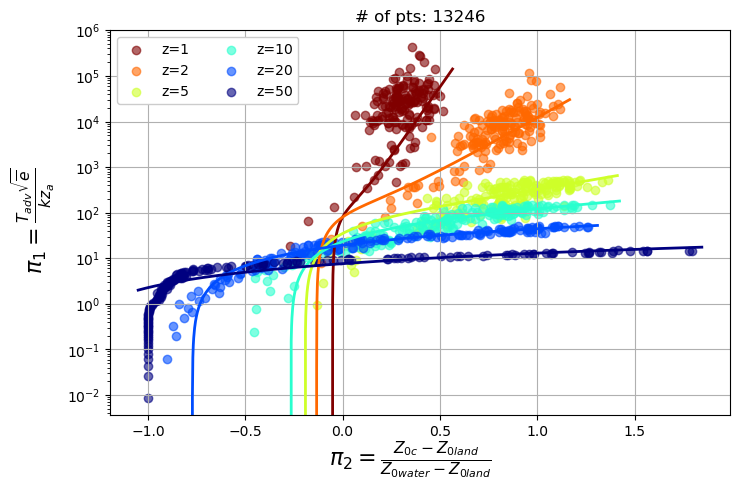

In [1125]:
## select heights

qheight = [1, 2, 5, 10, 20, 50]
#qheight = [2, 5, 10, 20]
mask = (ds.X_coast >= 0) & (ds.X_coast <= 1400) & (ds.z0<10) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

X, Z = np.meshgrid(ds.X_coast, ds.Height)

tke_adv = ds.U * calc.first_derivative(ds.TKE, axis='X_coast')
gamma = calc.first_derivative(ds.T, axis='Height')
tke = ds.TKE
tadv = (X/ds.U)
buoyancy = g/ds.T
N2 = buoyancy * gamma
f = 2*np.sin(36.5*np.pi/180)*(7.29e-5)
z0_land = 0.4
z0_water = 0.0000001

pi1 = ((tadv**1)*(tke**(1/2))/(vonk*Z)).where(mask, drop=True) 
#pi1 = (X*N2/(ds.U*f)).where(mask, drop=True) 
#pi1 = np.sqrt(X*f/ds.U).where(mask, drop=True) 
pi2 = ((ds.z0 - z0_land)/(z0_water-z0_land)).where(mask, drop=True)

N = len(qheight)
cmap = cm.jet_r
colors = cmap(np.linspace(0, 1, N)) 

opts = [
    [35, 20, 7], ## z=2
    [30, 20, 3], ## z=5
    [25, 20, 2], ## z=10
    [10, 18, 1.7], ## z=20
    [5.5, 10, 1.3], ## z=50
    [5.5, 10, 1.3], ## z=50
]

lower_bounds = [0, 0, 0]
upper_bounds = [100, 80, 43]

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.grid()

popt = np.zeros((len(qheight), 3))

for q,h in enumerate(qheight):
    xdata = -pi2.interp(Height=h)
    ydata = pi1.interp(Height=h)
    ax.scatter(xdata, ydata, color=colors[q], label=f'z={h}', alpha=0.6)

    # Fit the model to the data
    #initial_guess = [h/(z0_land-z0_water), 1/h, 2]  # Initial guesses for the parameters a and b
    initial_guess = opts[q]  # Initial guesses for the parameters a and b
    kwargs = {'maxfev': 10000, 'bounds': (lower_bounds, upper_bounds)}
    popt[q,:], pcov = curve_fit(sinh, xdata[xdata>-3], ydata[xdata>-3], p0=initial_guess, **kwargs)

    # Extract the optimal parameters
    print(f"Optimal parameters: a = {popt[q,0]:.2f}, b = {popt[q,1]:.2f}, c = {popt[q,2]:.2f}")
    xpts = np.linspace(xdata.min()-0.05, xdata.max()+0.05, 1000)
    ax.plot(xpts, sinh(xpts, *popt[q,:]), color=colors[q], lw=2)
    #ax.plot(xpts, sinh(xpts, *opts[q]), color=colors[q])

ax.set_title(f'# of pts: {pi1.size}')

fig.supylabel(r'$\pi_1=\frac{T_{adv}\sqrt{\overline{e}}}{kz_a}$', fontsize=16, x=0)
fig.supxlabel(r'$\pi_2=\frac{Z_{0c}-Z_{0land}}{Z_{0water}-Z_{0land}}$', fontsize=16, y=-0.02)

#ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([-1.35, 1.4])
#ax.set_xlim([8e-4, 1e6])
ax.legend(ncol=2, framealpha=1)

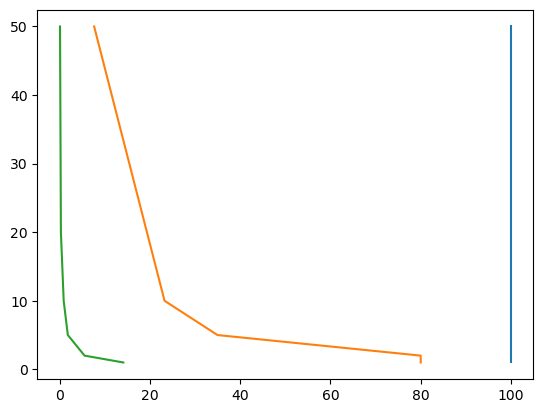

In [1121]:
ax = plt.axes()
ax.plot(popt[:,0], qheight, label='a')
ax.plot(popt[:,1], qheight, label='b')
ax.plot(popt[:,2], qheight, label='c')

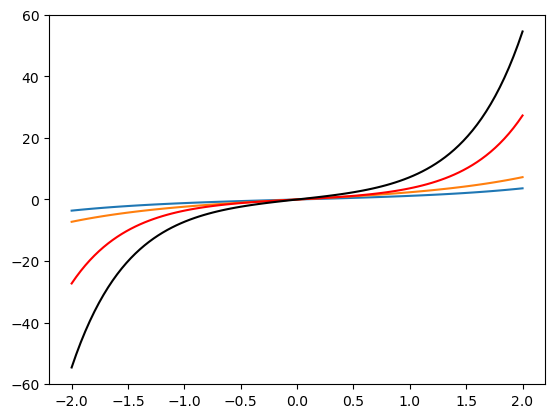

In [1020]:
x = np.linspace(-2, 2, 100)
plt.plot(x,np.sinh(x), c='C0')
plt.plot(x,2*np.sinh(x), c='C1')
plt.plot(x,np.sinh(2*x), c='r')
plt.plot(x,2*np.sinh(2*x), c='k')

In [213]:
ds.data_vars

Data variables:
    U        (Height, X_coast) float64 305kB 3.203 3.205 3.202 ... 4.701 4.702
    W        (Height, X_coast) float64 305kB -0.005786 0.006266 ... 0.02308
    V        (Height, X_coast) float64 305kB -0.0147 -0.01553 ... 0.01469
    T        (Height, X_coast) float64 305kB 286.1 286.1 286.1 ... 299.3 299.3
    UpUp     (Height, X_coast) float64 305kB 0.2301 0.2508 ... 0.003109 0.003112
    WpWp     (Height, X_coast) float64 305kB 0.007696 0.007576 ... 0.005745
    VpVp     (Height, X_coast) float64 305kB 0.118 0.1129 ... 0.007077 0.007079
    TKE      (Height, X_coast) float64 305kB 0.1779 0.1856 ... 0.007984 0.007968
    TpTp     (Height, X_coast) float64 305kB 0.01527 0.0009889 ... 0.00905
    UpWp     (Height, X_coast) float64 305kB -0.008249 -0.008026 ... 0.0005816
    WpTp     (Height, X_coast) float64 305kB -0.0008152 -0.0006877 ... -0.002288
    UpVp     (Height, X_coast) float64 305kB -0.05249 -0.04971 ... -1.06e-05
    VpWp     (Height, X_coast) float64 305kB 0

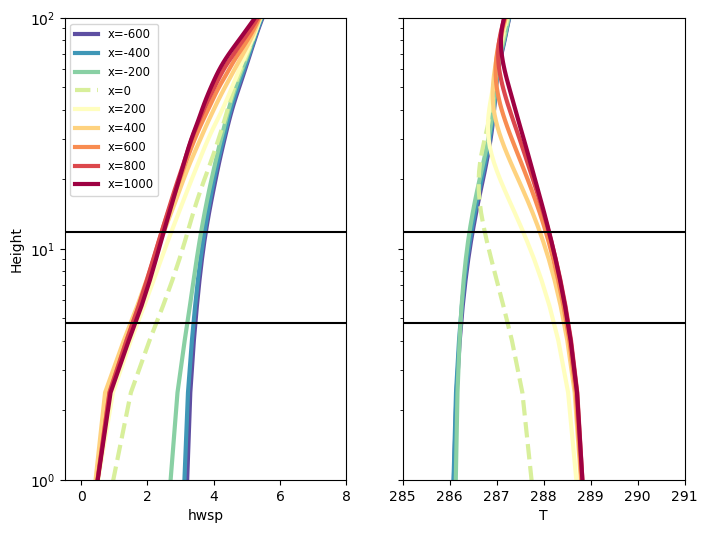

In [416]:
## step back, plot profiles of U(z)
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

xpos = np.arange(-600, 1001, 200)
N = len(xpos)

cmap = cm.Spectral_r
colors = cmap(np.linspace(0, 1, N)) 

fig, ax = plt.subplots(1,2, figsize=(8,6), sharey=True)

for n in range(N):
    if xpos[n]==0: ls='--'
    elif xpos[n]!=0: ls='-'
    (1*ds.hwsp.interp(X_coast=xpos[n])).plot(y='Height', ax=ax[0], color=colors[n], label=f'x={xpos[n]}', lw=3, ls=ls)
    ds.T.interp(X_coast=xpos[n]).plot(y='Height', ax=ax[1], color=colors[n], label=f'x={xpos[n]}', lw=3, ls=ls)

for a,axis in enumerate(ax):
    if a==0: 
        axis.legend(loc='upper left', fontsize='small')
        axis.set_xlim([-0.5, 8])
    elif a==1: 
        axis.set_xlim([285, 291])
        axis.set_ylabel('')
    axis.set_yscale('log')
    axis.set_ylim([1, 100])
    axis.plot(axis.get_xlim(), [4.78, 4.78], c='k')
    axis.plot(axis.get_xlim(), [11.78, 11.78], c='k')
    axis.set_title('')

(0.75, 20)

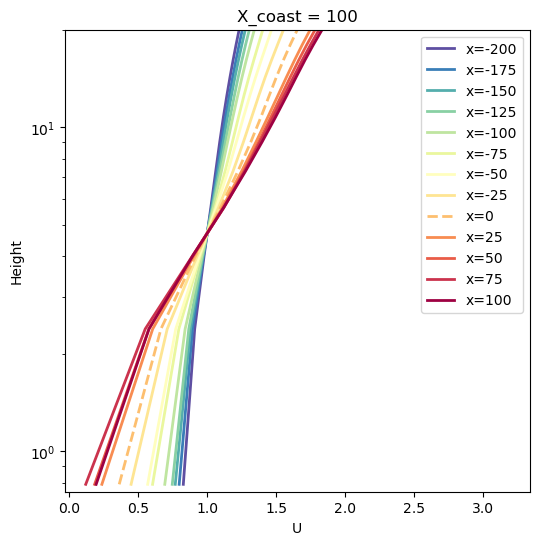

In [19]:
## step back, plot profiles of U(z)
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

xpos = np.arange(-200, 101, 25)
N = len(xpos)

cmap = cm.Spectral_r
# Generate N colors by sampling the colormap
colors = cmap(np.linspace(0, 1, N))  # Get N evenly spaced colors

fig, ax = plt.subplots(1,1, figsize=(6,6))

for n in range(N):
    wind_plt = ds.U.interp(X_coast=xpos[n])
    wind_plt = wind_plt / wind_plt.interp(Height=4.78)
    if xpos[n] == 0: ls = '--'
    else: ls = '-'
    wind_plt.plot(y='Height', ax=ax, color=colors[n], label=f'x={xpos[n]}', lw=2, ls=ls)

ax.legend()
ax.set_yscale('log')
ax.set_ylim([0.75, 20])

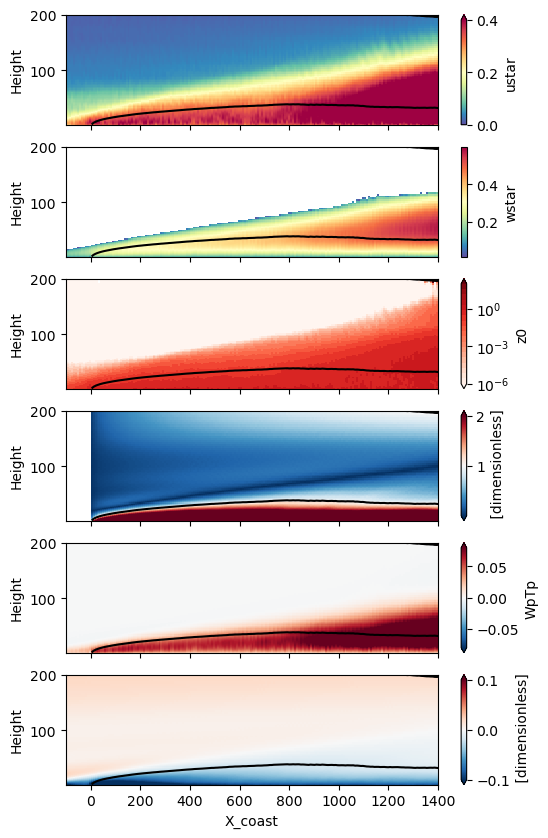

In [349]:
X, Z = np.meshgrid(ds.X_coast.values, ds.Height.values)
gamma = calc.first_derivative(ds.T)
N2 = (g/ds.T)*gamma

non_dim_ibl = ds.WpTp/(gamma*ds.U)
iblh_dyn = (ds.ustar**3/(N*ds.U))**(1/3)
plt_var = (ds.Tadv*N2**2/f)**(1/2)

fig, ax = plt.subplots(6,1, figsize=(6,10), sharex=True)
ax = ax.flatten()

ds.ustar.plot(ax=ax[0], cmap='Spectral_r', vmin=0, vmax=0.4)
ds.wstar.plot(ax=ax[1], cmap='Spectral_r')
ds.z0.where(ds.z0<10000).plot(ax=ax[2], x='X_coast', y='Height', cmap='Reds',extend='both', 
                              levels=np.logspace(1e-6, 100, 20), norm=LogNorm(vmin=1e-6, vmax=100))
plt_var.plot(ax=ax[3], cmap='RdBu_r', vmax=2, extend='both')
ds.WpTp.plot(ax=ax[4], cmap='RdBu_r', vmax=0.08, extend='both')
gamma.plot(ax=ax[5], cmap='RdBu_r', vmax=0.1, extend='both')

for n,axis in enumerate(ax):
    plt_var.plot.contour(ax=axis, levels=[1], colors='k')
    axis.set_ylim([2, 200])
    axis.set_xlim([-100, 1400])
    if n<5: axis.set_xlabel('')

/Users/jameshlywiak/miniconda3/envs/ABL/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jameshlywiak/miniconda3/envs/ABL/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jameshlywiak/miniconda3/envs/ABL/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jameshlywiak/miniconda3/envs/ABL/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jameshlywiak/miniconda3/envs/ABL/lib/python3.12/site-packages/xarray/core/variable.py:363: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


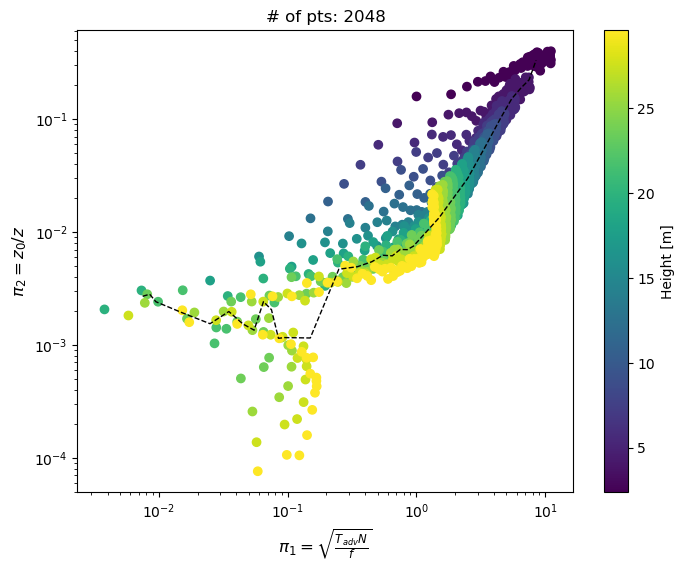

In [353]:
## all z0 below ~50 m

mask = (ds.Height <= 30) & (ds.Height >= 2) & (ds.X_coast<=1000) & (ds.X_coast >= 0) & (ds.z0<100) & (ds.z0>=1e-4)

pi1 = plt_var.where(mask, drop=True)
z0plt = ds.z0.where(mask, drop=True)
zplt = np.transpose(np.tile(z0plt.Height.values, (len(z0plt.X_coast.values), 1)))
pi2 = z0plt/zplt

bins = np.concatenate((
    np.arange(0.001, 0.01, 0.001), 
    np.arange(0.01, 0.1, 0.01), 
    np.arange(0.1, 1, 0.1),
    np.arange(1, 10, 1))
)
#bins = np.arange(0, 12, 0.5)
xplt = (bins[1:]+bins[:-1])/2
medians = np.zeros((len(bins)-1,))
for b,bin in enumerate(bins):
    if b==0: 
        prev_val = bin
    else:
        medians[b-1] = np.nanmedian(pi2.where((pi1>=prev_val) & (pi1<bin), drop=True).values)
        prev_val = bin

fig, ax = plt.subplots(1,1, figsize=(8,6))

p1=ax.scatter(pi1, pi2, c=zplt)
#p2=ax.scatter(xplt, medians, c='k', marker='^', s=100)
p2=ax.plot(xplt, medians, c='k', ls='--', lw=1)

ax.set_title(f'# of pts: {pi1.size}')

fig.colorbar(p1, location='right', label='Height [m]')
ax.set_xlabel(r'$\pi_1=\sqrt{\frac{T_{adv}N}{f}}$', fontsize=12)
ax.set_ylabel(r'$\pi_2=z_0/z$', fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')